# Application: Differential ablation - pedestalled, relict lakes (with damage!)
This notebook reproduces Figure 2 from [MacAyeal et al.](https://www.cambridge.org/core/journals/journal-of-glaciology/article/treatment-of-iceshelf-evolution-combining-flow-and-flexure/AD266BB055752B4DC817FEAAA86363A3), using the coupled flow-viscous-flexure workflow outlined [here](https://github.com/chrismiele/weird_flex/blob/main/coupled_flow_flexure/coupled_flow_flexure_viscous.ipynb). In this example, surface ablation is driven by a dark debris field on the shelf, which is present everywhere except directly over a relict, frozen-over lake. Consequently, the shelf's surface falls below flotation everywhere except at the lake, where the surface remains unmelted, forming a relatively elevated pedestal. This imbalance forces an upward viscous deflection rate which, besides raising the bulk of the shelf back to equilibrium, also raises the edges of the pedestal a bit higher than flotation, resulting in an emergent imbalance which forces further flexure. 

This script allows a choice between two possible damage mechanisms:

First, damage can be forced by the Nye crevasse depth criterion, where the flexural stresses produce surface and basal crevasses as described [here](https://github.com/chrismiele/weird_flex/blob/main/fracture/nye_crevasse_coupled_flow_flexure.ipynb). We obtain a dimensionless fracture density by taking the sum of surface and basal crevasse depths and normalizing by the thickness. Damage is then advected forward with flow, and compared with the Nye crevasse depth calculations for the next iteration. The damage field is updated only if crevasses have deepened (i.e., healing does not occur). 

Second, we can apply the method of Albrecht and Levermann, but with the depth-averaged principal strain rate from viscous flexure in place of the principal strain rate from flow. Again, healing is not permitted. 

In both cases, each iteration's damage is used to reduce the flexural viscosity, thus coupling damage with the flow and flexure fields. Pretty sure the Nye approach is better because a) it can resolve the distinction between surface and basal crevasses, which might be interesting in some applications, b) it doesn't invoke any poorly constrained tuning parameters (e.g., the damage rate $\gamma$ of Albrecht and Levermann), and c) it generalizes to the LEFM treatment.  

## Imports

In [1]:
path = '/home/sermilik/firedrake_stuff/figures/flow_flexure' #modify to preferred destination for saving figures
damage_source = 'albrecht_levermann' #can be 'nye', 'albrecht_levermann', or 'none'

from abc import ABC
from firedrake import *
import icepack
from icepack.calculus import sym_grad, grad, div, FacetNormal
from icepack.models.viscosity import membrane_stress
from icepack.optimization import MinimizationProblem, NewtonSolver
from icepack.utilities import eigenvalues, default_solver_parameters
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import os
import tqdm

## Mesh, function spaces, trial and test functions

Although MacAyeal et al. model 14 km of shelf, we will model only 6 km around the pedestalled lake (nothing interesting ends up happening more than a kilometer or so beyond the lake margins anyway). Because this is essentially a 1D example, we can set the lateral resolution to a single element: 

In [2]:
nx, ny = 200, 1 #number of elements in x, y 
Lx, Ly = 6000, 6000 #length, width in meters
mesh = RectangleMesh(nx, ny, Lx, Ly)
x, y = SpatialCoordinate(mesh)

Q1 = FunctionSpace(mesh, 'Argyris', 5) #Argyris elements for solving 4th order flexure problem
Q2 = FunctionSpace(mesh, 'CG', 2) #CG elements for icepack's prognostic solve, which does not appreciate Argyris elements
V = VectorFunctionSpace(mesh, 'CG', 2)  #CG elements for solving SSA problem
S = TensorFunctionSpace(mesh, 'DG', 1) #DG elements for interpolating tensors arising from the velocity field

η = Function(Q1) #deflection rate
w = TestFunction(Q1)
ddη = grad(grad(η)) 
ddw = grad(grad(w))
Δη = div(grad(η)) 
Δw = div(grad(w)) 

u = Function(V) #velocity
v = TestFunction(V) #note the Roman v, not to be confused with Greek ν introduced below

## Physical constants, shelf geometry

In [3]:
from icepack.constants import year #number of seconds in a year
ρ_i = 910 #icepack's default is 917 kg/m^3
ρ_w = 1032 #icepack's default is 1024 kg/m^3
ϱ = ρ_i/ρ_w #density ratio
g = 9.81 #gravity in N/kg
T = Constant(273.15) #temperature (K). 273.15 is freezing
A = icepack.rate_factor(T) #A from Glen's law
ν_f = 5e15/year #Pa*s to Pa*yrs
γ = 400.0 #arbitrarily-chosen damage rate for Albrecht-and-Levermann-style damage

H_gl = 50 #thickness at upstream boundary (m)
thick_grad = 0 #thickness gradient 
H0 = project(H_gl + thick_grad*x, Q2) #initial thickness projected onto CG elements
b0 = project(-ϱ*H0, Q2) #initial basal elevation
s0 = project(H0 + b0, Q2) #initial surface elevation

## Modify some icepack modules to solve non-equilibrium SSA

Unlike the classic SSA, this variation does not assume the shelf to be exactly at flotation. We'll tweak icepack's ```gravity``` and ```terminus``` modules to allow the driving stress and terminal cliff boundary condition to reflect this departure from equilibrium. 

In [4]:
ρ_I, ρ_W = ρ_i/1e6/year**2, ρ_w/1e6/year**2 #put into icepackese
G = g*year**2

def gravity(**kwargs): #see RHS of Eq. 44 in MacAyeal et al. (2021)
    u, H, s = itemgetter('velocity', 'thickness', 'surface')(kwargs)
    return -0.5* ρ_I*G*inner(grad(H**2), u) + 0.5*ρ_W*G*inner(grad((s - H)**2), u)

def terminus(**kwargs): #see Eq. 45 from MacAyeal et al. (2021)
    u, H, s = itemgetter('velocity', 'thickness', 'surface')(kwargs)
    mesh = u.ufl_domain()
    ν = FacetNormal(mesh)
    return 0.5*ρ_I*G*H**2*inner(u, ν) - 0.5*ρ_W*G*(s - H)**2*inner(u, ν)

def effective_viscosity(**kwargs): #also define a function that returns the effective viscosity
    n = 3
    u = itemgetter('velocity')(kwargs)
    ε = sym(grad(u))
    ε_min = Constant(kwargs.get('strain_rate_min', icepack.constants.strain_rate_min))
    ε_e = icepack.models.viscosity._effective_strain_rate(ε, ε_min) 
    ν = 1/2*A**(-1/n)*ε_e**(1/n - 1) #effective viscosity in MPa*yrs
    return ν*1e6 #return ν in units of Pa*yrs

## Write the transport solver

In [5]:
#####################################
#####################################
### transport equation and solver ###
#####################################
#####################################

# Copyright (C) 2023 by Daniel Shapero <shapero@uw.edu>
#
# This file is part of icepack.
#
# icepack is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# The full text of the license can be found in the file LICENSE in the
# icepack source directory or at <http://www.gnu.org/licenses/>.

###############################################
###############################################
### copy/paste icepack's transport equation ###
###############################################
###############################################

class TransportEquation(ABC):
    def __init__(self, field_name, conservative):
        self._field_name = field_name
        self._conservative = conservative

    def flux(self, **kwargs):
        keys = (self._field_name, "velocity")
        q, u = itemgetter(*keys)(kwargs)
        q_inflow = kwargs.get(f"{self._field_name}_inflow", Constant(0.0))

        if q.ufl_shape != ():
            raise NotImplementedError(
                "Transport equation only implemented for scalar problems!"
            )

        Q = q.function_space()
        φ = TestFunction(Q)

        mesh = Q.mesh()
        n = FacetNormal(mesh)
        #ds = ds if mesh.layers is None else ds_v

        if self._conservative:
            flux_cells = -inner(q * u, grad(φ)) * dx
        else:
            flux_cells = -q * div(u * φ) * dx

        flux_out = q * max_value(0, inner(u, n)) * φ * ds
        flux_in = q_inflow * min_value(0, inner(u, n)) * φ * ds

        if q.ufl_element().family() == "Discontinuous Lagrange":
            f = q * max_value(0, inner(u, n))
            flux_faces = (f("+") - f("-")) * (φ("+") - φ("-")) * dS
            return flux_cells + flux_faces + flux_out + flux_in

        return flux_cells + flux_out + flux_in

    def sources(self, **kwargs): #tweaking this to only permit (thickness, thickness_accumulation), (damage, damage_accumulation), etc.
        keys = (self._field_name, f"{self._field_name}_accumulation")
        ψ, a = itemgetter(*keys)(kwargs)
        φ = TestFunction(ψ.function_space())
        return a * φ * dx

#################################################################
#################################################################
### essentially copy/paste the relevant bits from flow_solver ###
#################################################################
#################################################################

class TransportSolver:
    def __init__(self, model, **kwargs):
        
        self._model = model
        self._fields = {}

        # Prepare the prognostic solver
        prognostic_parameters = kwargs.get(
            "prognostic_solver_parameters", default_solver_parameters
        )

        self._prognostic_solver = LaxWendroff(
            model, self._fields, prognostic_parameters
        )

    @property
    def model(self):
        r"""The physics model that this object solves"""
        return self._model

    @property
    def fields(self):
        r"""Dictionary of all fields that are part of the simulation"""
        return self._fields

    def prognostic_solve(self, dt, **kwargs):
        r"""Solve the prognostic model physics for the new value of the chosen scaler field"""
        return self._prognostic_solver.solve(dt, **kwargs)

class LaxWendroff:
    def __init__(self, model, fields, solver_parameters):
        self._model = model
        self._fields = fields
        self._solver_parameters = solver_parameters

    def setup(self, **kwargs):
        r"""Create the internal data structures that help reuse information
        from past prognostic solves"""
        for name, field in kwargs.items():
            if name in self._fields.keys():
                self._fields[name].assign(field)
            else:
                if isinstance(field, Constant):
                    self._fields[name] = Constant(field)
                elif isinstance(field, Function):
                    self._fields[name] = field.copy(deepcopy=True)
                else:
                    raise TypeError(
                        "Input %s field has type %s, must be Constant or Function!"
                        % (name, type(field))
                    )

        dt = Constant(1.0)
        ψ = self._fields[self._model._field_name] #generalized from thickness h to scalar field ψ
        u = self._fields["velocity"]
        ψ_0 = ψ.copy(deepcopy=True)

        Q = ψ.function_space()
        mesh = Q.mesh()
        n = FacetNormal(mesh)
        outflow = max_value(0, inner(u, n))
        inflow = min_value(0, inner(u, n))

        # Additional streamlining terms that give 2nd-order accuracy
        q = TestFunction(Q)
        #ds = ds if mesh.layers is None else ds_v
        flux_cells = -div(ψ * u) * inner(u, grad(q)) * dx
        flux_out = div(ψ * u) * q * outflow * ds
        flux_in = div(ψ_0 * u) * q * inflow * ds
        d2ψ_dt2 = flux_cells + flux_out + flux_in

        sources = self._model.sources(**self._fields)
        flux = self._model.flux(**self._fields)
        dψ_dt = sources - flux
        F = (ψ - ψ_0) * q * dx - dt * (dψ_dt + 0.5 * dt * d2ψ_dt2)

        problem = NonlinearVariationalProblem(F, ψ)
        self._solver = NonlinearVariationalSolver(
            problem, solver_parameters=self._solver_parameters
        )

        self._ψ_old = ψ_0
        self._timestep = dt

    def solve(self, dt, **kwargs):
        r"""Compute the evolution of the chosen scalar field after time `dt`"""
        if not hasattr(self, "_solver"):
            self.setup(**kwargs)
        else:
            for name, field in kwargs.items():
                self._fields[name].assign(field)

        ψ = self._fields[self._model._field_name]
        self._ψ_old.assign(ψ)
        self._timestep.assign(dt)
        self._solver.solve()
        return ψ.copy(deepcopy=True)

## Set up the solver

Most of this cell is similar to the corresponding cell in the [coupled flow-viscous-deflection solver](https://github.com/chrismiele/weird_flex/blob/main/coupled_flow_flexure/coupled_flow_flexure_viscous.ipynb). We'll also define ```D``` to be a scalar field representing the presence or absence of debris, attaining a value of 0 above the lake and 1 everywhere else. Surface mass balance will be -1 meter per year where debris is present and 0 where debris is absent. Instead of properly transporting the debris field, we'll just move it forward at the boundary condition flow rate of 50 meters per year (the shelf is only 50 meters thick in this example, so extension is minimal, and the shelf essentially just flows uniformly at this rate). 

In [6]:
################################
################################
### parameters for iteration ###
################################
################################

Δt = 1/10 #length of timestep in years
num_timesteps = int(20/Δt) #spin up for 20 years

##################################
##################################
### parameters for flow solver ###
##################################
##################################

ux_gl = 50 #upstream boundary boundary condition in meters per year
u0 = project(as_vector([ux_gl, 1e-50]), V) #initial velocity (u_x, u_y) for imposing Dirichlet BCs
α = 1e10 #arbitrary large number for penalty method

opts = {
    'dirichlet_ids': [1], #boundaries are labeled (1, 2, 3, 4) = (upstream, downstream, left, right)
    'side_wall_ids': [3, 4],
    'ice_front_ids': [2],
    'diagnostic_solver_type': 'petsc',
    'diagnostic_solver_parameters': {
        'ksp_type': 'cg',
        'pc_type': 'mg',
        'pc_mg_cycle_type': 'w',
        'snes_line_search_type': 'cp',
    },
    'prognostic_solver_parameters': {
        'ksp_type': 'gmres',
        'pc_type': 'ilu',
    },
}

flow_model = icepack.models.IceShelf(gravity = gravity, terminus = terminus) #model is icepack's SSA, but with our own physics

flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)

#########################
#########################
### debris transport ####
#########################
#########################

# debris_model = TransportEquation(field_name = 'debris', conservative = False)
# debris_solver = TransportSolver(debris_model, **opts)

r = 1000 #radius of the relict lake
px = Lx/2 #center coordinate of the lake
D = conditional(abs(x - px) < r, 0, 1) #debris cover is 0 within 1000 meters of px, and 1 elsewhere
D = project(D, Q2)

a = -D #mass balance rate in meters per year, forced by debris cover

################################
################################
### initialize damage solver ###
################################
################################

damage_model = TransportEquation(field_name = 'damage', conservative = False)
damage_solver = TransportSolver(damage_model, **opts)

#############################
#############################
### plot initial geometry ###
#############################
#############################

os.chdir(path) #for saving figures
X = np.array([(k, Ly/2) for k in range (Lx+1)]) #along-flow line for getting geometry profiles
s0_profile = s0.at(X, tolerance = 1e-10)
b0_profile = np.array(project(b0 + 25, Q2).at(X, tolerance = 1e-10)) #add 25 meters to the basal profile for a better plot window

plt.figure()
plt.title('centerline profile, $t$ = 0.0 years')
plt.plot(s0_profile, color='red', label = 'surface')
plt.plot(b0_profile, color='blue', label = 'base + 25 m')
plt.legend(loc = 'center left')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('elevation (m)')
plt.ylim(-20, 8)
plt.yticks(np.arange(-20, 8, 2))
plt.xticks(np.arange(0, Lx + 1, 1000))
plt.grid(linewidth=0.2)
plt.twinx()
plt.ylim(0, 1.5)
plt.ylabel('fracture density')
plt.plot([0, Lx], [0, 0], color='k', linestyle ='dotted', label = 'damage')
plt.legend(loc = 'center right')
plt.savefig('iteration_0')
plt.close() #comment this line out to show the plot

## Iteratively solve the flow-flexure problem

We'll also save plots of the surface and basal elevation profiles, along the centerline, at each timestep. The final iteration is shown below. 

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [06:13<00:00,  1.87s/it]


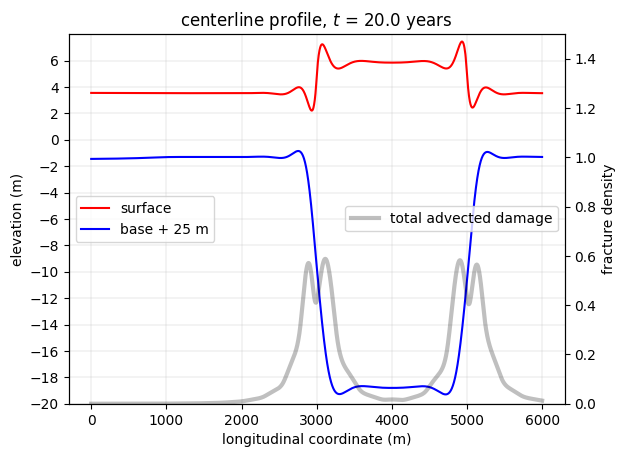

In [7]:
u, H, s, b = u0.copy(deepcopy=True), H0.copy(deepcopy=True), s0.copy(deepcopy=True), b0.copy(deepcopy=True) #initialize
damage = Function(Q2).project(Constant(0)) #zero damage initially
d_s, d_b = damage.copy(deepcopy = True), damage.copy(deepcopy = True)

for step in tqdm.trange(num_timesteps):
        
    #############################
    #############################
    ### get velocity solution ###
    #############################
    #############################
    
    u = flow_solver.diagnostic_solve(velocity = u, side_friction = Constant(0), 
                                     thickness = H, surface = s, fluidity = A)
    
    ##################################
    ##################################
    ### dynamically thin the shelf ###
    ##################################
    ##################################
    
    s = flow_solver.prognostic_solve(Δt, thickness = s, velocity = u,
                                     thickness_inflow = s, accumulation = Constant(0))
    b = flow_solver.prognostic_solve(Δt, thickness = b, velocity = u,
                                     thickness_inflow = b, accumulation = Constant(0))
    H = s - b

    ########################################
    ########################################
    ### calculate some useful parameters ###
    ########################################
    ########################################

    ε_f, τ_f = Function(S), Function(S)
    ν = effective_viscosity(velocity = u)
    ε_f.project(sym(grad(u))) #strain rate tensor, /yr
    τ_f.project(2*ν*ε_f) #depth-averaged deviatoric stress tensor in Pascals
    p = -tr(τ_f) + 1/2*ρ_i*g*H #depth-averaged pressure
    σ_f = τ_f - p*Identity(2) #depth-averaged net stress 
    ν_damaged = ν_f*(1 - damage) #reduce the flexural viscosity with damage

    ##############################
    ##############################
    ### transport the sediment ###
    ##############################
    ##############################

    px += ux_gl*Δt #because there isn't much extension, we'll just advect the debris field uniformly at the boundary flow rate
    D = conditional(abs(x - px) < r, 0, 1) #debris cover is 0 within 1000 meters of px, and 1 elsewhere
    # D = debris_solver.prognostic_solve(Δt, debris = D, debris_inflow = D, debris_accumulation = Constant(0))
    a = Function(Q2).project(-D) #surface mass balance in meters per year


    ######################
    ######################
    ### flex the shelf ###
    ######################
    ######################

    h_ab = s + a*Δt + η*Δt - (1 - ϱ)*(H + a*Δt) #this will be the height above buoyancy once η is known

    #force flexure with surface mass balance (see Eq. 57a and 57c of MacAyeal et al. 2021)
    f = conditional(h_ab < 0, #if height above buoyancy is negative after flexing:
                    -ρ_w*g*h_ab, #f acts upward via buoyancy
                    -ρ_i*g*h_ab) #else: f acts downward via gravity
    
    #additionally force flexure with the velocity field, as in Eq. 57e 
    f += H*inner(σ_f, ddη)*Δt #Eq. 57e

    L = 1/6*ν_damaged*H**3*inner(ddη, ddw)*dx + 1/6*ν_damaged*H**3*Δη*Δw*dx - f*w*dx 
    L += 0.5*α**2*h_ab*w*ds(1) #constrain η so that h_ab is zero on the upstream boundary
    L += 0.5*α**2*h_ab*w*ds(2) #and the same at the downstream boundary

    solve(L == 0, η) #η is returned in meters per year

    ########################
    ########################
    ### damage the shelf ###
    ########################
    ########################

    if damage_source == 'nye':
        λ_1, λ_2 = eigenvalues(-ddη) #eigenvalues of depth-invariant part of the flexural strain rate
        τ_ν = -2*ν_damaged*ddη #depth-invariant part of the flexural stress (excludes the ζ term)
        P_surf = tr(τ_ν)*H/2 #pressure at the surface
        P_base = tr(τ_ν)*H/2 + ρ_i*g*H #pressure at the base

        damage_old = damage_solver.prognostic_solve(Δt, velocity = u, damage = damage, damage_inflow = Constant(0), #advect pre-existing damage
                                                    damage_accumulation = interpolate(a*Δt/H, Q2)) #crevasses can be melted out
        damage_old =  max_value(damage_old, 0) #don't let crevasses diminish to negative values
     
        ds_new = conditional(P_surf < 2*ν_f*λ_1*H/2, 
                                  (1/2*H*2*ν_damaged*λ_1 + 1/2*H*tr(τ_ν))/(2*ν_damaged*λ_1 + tr(τ_ν) + ρ_i*g), 
                                  0) #new surface crevasses from flexure
        ds_new = max_value(0, ds_new) #exclude any spurious values
        db_new = conditional(P_base < -2*ν_damaged*λ_2*H/2 - ρ_w*g*(s - H), #if glaciostatic pressure < flexural tension + basal water pressure:
                                  (1/2*2*ν_damaged*λ_2*H + 1/2*tr(τ_ν)*H + ρ_i*g*H + ρ_w*g*(s - H))/(2*ν_damaged*λ_2 + tr(τ_ν) + (ρ_i - ρ_w)*g), 
                                  0) #new basal crevasses from flexure
    
        damage_new = (ds_new + db_new)/H #the instantaneous damage field, given current configuration
    
        damage = Function(Q2).project(max_value(damage_old, damage_new)) #update only if damage has increased; otherwise, use advected values

    elif damage_source == 'albrecht_levermann':
        λ_1, λ_2 = eigenvalues(-ddη) #eigenvalues of depth-invariant part of the flexural strain rate
        ε_1 = 1/8*H*(λ_1 - λ_2) #depth-averaged principal extensional strain rate from flexure
        
        damage_accumulation = Function(Q2).project(γ*ε_1*(1 - damage)) #damage accumulation term from Albrecht and Levermann
        damage = damage_solver.prognostic_solve(Δt, velocity = u, damage = damage, damage_inflow = Constant(0),
                                          damage_accumulation = damage_accumulation)
    
    #######################
    #######################
    ### adjust geometry ###
    #######################
    #######################
    
    b = project(b + η*Δt, Q2) #b is modified by the deflection
    s = project(s + a*Δt + η*Δt, Q2) #s is modified by deflection and surface mass balance 
    H = project(s - b, Q2) #new thickness
        
    #################
    #################
    ### save figs ###
    #################
    #################
    
    #at each step, save plots of the surface and basal elevation profiles along "X"
    s_profile = np.array(s.at(X, tolerance = 1e-10))
    b_profile = np.array(project(b + 25, Q2).at(X, tolerance = 1e-10))
    if damage_source != 'none':
        damage_profile = np.array(project(damage, Q2).at(X, tolerance = 1e-10))
    if damage_source == 'nye':
        new_profile = np.array(project(damage_new, Q2).at(X, tolerance = 1e-10))
        ds_profile = np.array(project(ds_new/H, Q2).at(X, tolerance = 1e-10))
        db_profile = np.array(project(db_new/H, Q2).at(X, tolerance = 1e-10))
    
    plt.figure()
    plt.title('centerline profile, $t$ = {:.1f} years'.format(step*Δt + Δt))
    plt.xlabel('longitudinal coordinate (m)')
    plt.ylabel('elevation (m)')
    plt.plot(s_profile, color='red', label = 'surface')
    plt.plot(b_profile, color='blue', label = 'base + 25 m')
    plt.legend(loc = 'center left')
    plt.ylim(-20, 8)
    plt.yticks(np.arange(-20, 8, 2))
    plt.xticks(np.arange(0, Lx + 1, 1000))
    plt.grid(linewidth=0.2)
    if damage_source != 'none':
        plt.twinx()
        plt.plot(damage_profile, color='k', linestyle = 'solid', label = 'total advected damage', linewidth=3, alpha = 0.25)
        if damage_source == 'nye':
            plt.plot(ds_profile, color='k', linestyle = 'dashed', label = 'instantaneous surface damage')
            plt.plot(db_profile, color='k', linestyle = 'dotted', label = 'instantaneous basal damage')
        plt.ylabel('fracture density')
        plt.legend(loc = 'center right')
        plt.ylim(0, 1.5)
    plt.savefig('iteration_{}'.format(step + 1))
    if step < num_timesteps - 1:
        plt.close() #save all plots but only show the last iteration 